In [2]:
!pip install nltk wordcloud

In [3]:
!pip install nltk

In [4]:
!pip install contractions emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.3 MB/s eta 0:00:00


In [5]:
import nltk
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from scipy.sparse import hstack
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import contractions
import emoji
from nltk.stem import WordNetLemmatizer

# Suppress warnings
warnings.filterwarnings('ignore')


In [6]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:

lemmatizer = WordNetLemmatizer()


def preprocess_text(text):

    text = text.lower()


    text = contractions.fix(text)


    text = emoji.replace_emoji(text, replace='')


    text = re.sub(r'\s+', ' ', text).strip()


    text = text.translate(str.maketrans('', '', string.punctuation))


    tokens = word_tokenize(text)


    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]


    tokens = [lemmatizer.lemmatize(word) for word in tokens]


    return ' '.join(tokens)

In [12]:
# Load the datasets
train_data = pd.read_csv("SMS_train.csv", encoding='latin1')
test_data = pd.read_csv("SMS_test.csv", encoding='latin1')


merged_data = pd.concat([train_data, test_data], ignore_index=True)


print("Columns in merged_data:", merged_data.columns)


merged_data['Processed_Text'] = merged_data['Message_body'].apply(preprocess_text)


merged_data.head()

Columns in merged_data: Index(['S. No.', 'Message_body', 'Label'], dtype='object')


,S. No.,Message_body,Label,Processed_Text
0,1,Rofl. Its true to its name,Non-Spam,rofl true name
1,2,The guy did some bitching but I acted like i'd...,Non-Spam,guy bitching acted like would interested buyin...
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam,pity mood soany suggestion
3,4,Will ü b going to esplanade fr home?,Non-Spam,ü b going esplanade fr home
4,5,This is the 2nd time we have tried 2 contact u...,Spam,2nd time tried 2 contact £750 pound prize 2 cl...


In [13]:
train_data.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [14]:
test_data.head()

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",Spam
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam
3,4,URGENT! Your Mobile number has been awarded wi...,Spam
4,5,Someone has contacted our dating service and e...,Spam


In [15]:
merged_data.head()

,S. No.,Message_body,Label,Processed_Text
0,1,Rofl. Its true to its name,Non-Spam,rofl true name
1,2,The guy did some bitching but I acted like i'd...,Non-Spam,guy bitching acted like would interested buyin...
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam,pity mood soany suggestion
3,4,Will ü b going to esplanade fr home?,Non-Spam,ü b going esplanade fr home
4,5,This is the 2nd time we have tried 2 contact u...,Spam,2nd time tried 2 contact £750 pound prize 2 cl...


In [16]:
print("Dataset Info:")
print(merged_data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082 entries, 0 to 1081
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   S. No.          1082 non-null   int64 
 1   Message_body    1082 non-null   object
 2   Label           1082 non-null   object
 3   Processed_Text  1082 non-null   object
dtypes: int64(1), object(3)
memory usage: 33.9+ KB
None


In [17]:
print("\nDescriptive Statistics:")
print(merged_data.describe())



Descriptive Statistics:
            S. No.
count  1082.000000
mean    430.940850
std     292.259931
min       1.000000
25%     146.250000
50%     416.500000
75%     686.750000
max     957.000000


In [18]:
print("\nMissing Values:")
print(merged_data.isnull().sum())



Missing Values:
S. No.            0
Message_body      0
Label             0
Processed_Text    0
dtype: int64


In [19]:
print("\nClass Distribution:")
print(merged_data['Label'].value_counts())


Class Distribution:
Label
Non-Spam    884
Spam        198
Name: count, dtype: int64


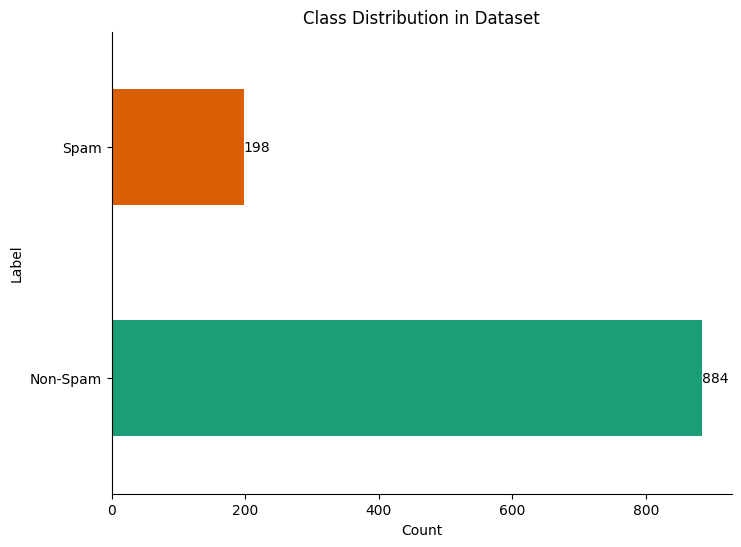

In [20]:
plt.figure(figsize=(8, 6))
ax = merged_data['Label'].value_counts().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Class Distribution in Dataset')
for i in ax.containers:
    ax.bar_label(i)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

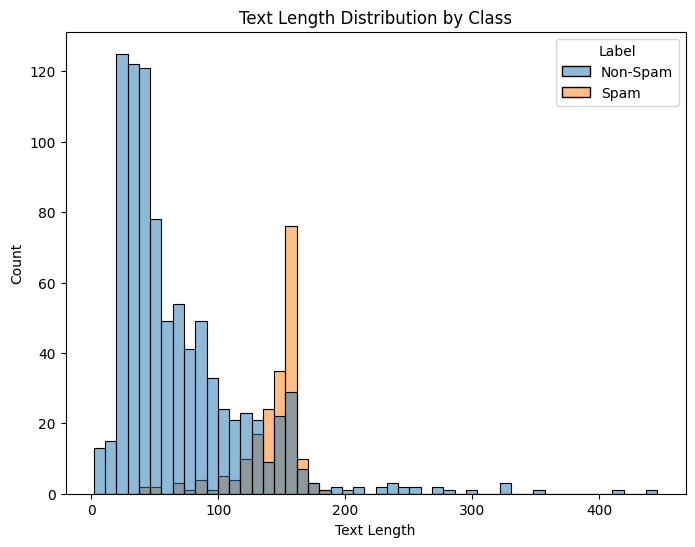

In [21]:
merged_data['text_length'] = merged_data['Message_body'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(data=merged_data, x='text_length', hue='Label', bins=50)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()



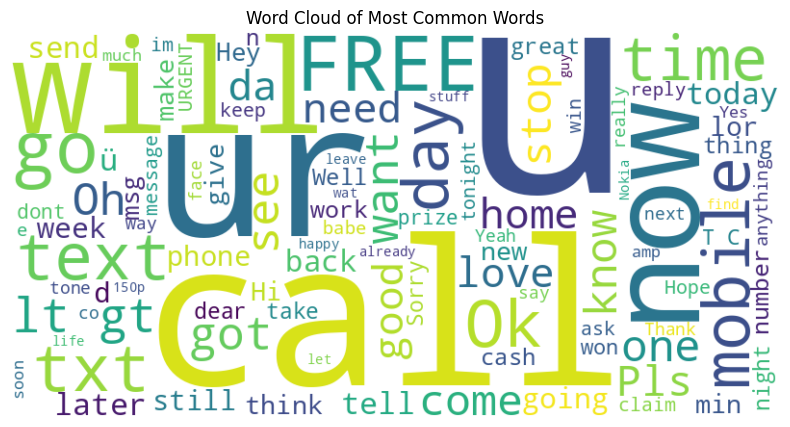

In [22]:
all_text = ' '.join(merged_data['Message_body'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()

In [23]:
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

merged_data['avg_word_length'] = merged_data['Message_body'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else [0]))
merged_data['punctuation_count'] = merged_data['Message_body'].apply(count_punctuation)


In [24]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stopwords_list = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stopwords_list]
    return ' '.join(filtered_tokens)

merged_data['Message_body'] = merged_data['Message_body'].apply(preprocess_text)


In [25]:
# Apply preprocessing to train and test data
print(merged_data.columns)
merged_data['Message_body'] = merged_data['Message_body'].apply(preprocess_text)
merged_data.head()

Index(['S. No.', 'Message_body', 'Label', 'Processed_Text', 'text_length',
       'avg_word_length', 'punctuation_count'],
      dtype='object')


,S. No.,Message_body,Label,Processed_Text,text_length,avg_word_length,punctuation_count
0,1,rofl true name,Non-Spam,rofl true name,26,3.500000,1
1,2,guy bitching acted like interested buying some...,Non-Spam,guy bitching acted like would interested buyin...,125,3.846154,1
2,3,pity mood suggestions,Non-Spam,pity mood soany suggestion,57,4.800000,7
3,4,ü b going esplanade fr home,Non-Spam,ü b going esplanade fr home,36,3.625000,1
4,5,nd time tried contact u u pound prize claim ea...,Spam,2nd time tried 2 contact £750 pound prize 2 cl...,160,4.366667,8


In [26]:
# تحويل النصوص المعالجة إلى تمثيل عددي
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(merged_data['Processed_Text'])

# استخراج الميزات الإضافية (طول النص، متوسط طول الكلمة، عدد علامات الترقيم)
def extract_features(text):
    text_length = len(text)
    avg_word_length = np.mean([len(word) for word in text.split()]) if text.split() else 0
    punctuation_count = sum([1 for char in text if char in string.punctuation])
    return [text_length, avg_word_length, punctuation_count]

custom_features = np.array([extract_features(text) for text in merged_data['Message_body']])

# دمج الميزات النصية والإضافية
X = hstack((X_text, custom_features))

# تحويل التسميات إلى 0 و 1
y = merged_data['Label'].map({'Spam': 1, 'Non-Spam': 0})

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [28]:
models = {
    'SVM': {
        'model': SVC(),
        'params': {
            'kernel': ['linear'],
            'C': [10, 100, 200],
            'gamma': ['scale']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100]
        }
    },
    'Multinomial NB': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.5],
            'max_depth': [3, 5, 7, 9]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(verbose=-1),
        'params': {
            'n_estimators': [50, 100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.5],
            'max_depth': [-1, 5, 10, 20]
        }
    }
}


In [29]:
def evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, cv_splits=5):
    grid_search = GridSearchCV(model, param_grid, cv=cv_splits, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    mean_cv_score = grid_search.best_score_

    # Train on full training data
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return mean_cv_score, test_accuracy, class_report, conf_matrix, grid_search.best_params_


In [30]:
results = {}

for model_name, model_info in models.items():
    print(f"Evaluating: {model_name}")
    mean_cv_score, test_accuracy, class_report, conf_matrix, best_params = evaluate_model(
        model_info['model'], model_info['params'], X_train, y_train_encoded, X_test, y_test_encoded
    )
    results[model_name] = {
        'Mean CV Score': mean_cv_score,
        'Test Accuracy': test_accuracy,
        'Classification Report': class_report,
        'Confusion Matrix': conf_matrix,
        'Best Params': best_params
    }



Evaluating: SVM
Evaluating: Logistic Regression
Evaluating: Multinomial NB
Evaluating: Random Forest
Evaluating: Gradient Boosting
Evaluating: LightGBM



Model: SVM
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Mean Cross-Validation Score: 0.9584
Test Accuracy: 0.9724

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       181
           1       0.94      0.89      0.91        36

    accuracy                           0.97       217
   macro avg       0.96      0.94      0.95       217
weighted avg       0.97      0.97      0.97       217



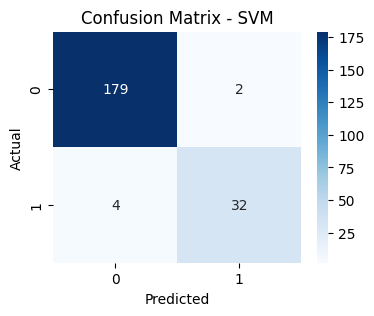


Model: Logistic Regression
Best Parameters: {'C': 100}
Mean Cross-Validation Score: 0.9526
Test Accuracy: 0.9585

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       181
           1       0.94      0.81      0.87        36

    accuracy                           0.96       217
   macro avg       0.95      0.90      0.92       217
weighted avg       0.96      0.96      0.96       217



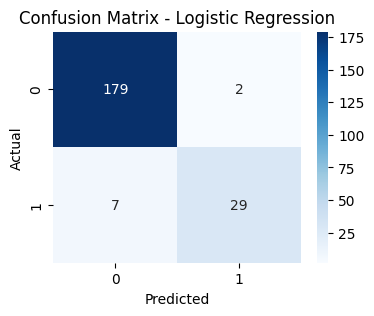


Model: Multinomial NB
Best Parameters: {'alpha': 0.1}
Mean Cross-Validation Score: 0.9561
Test Accuracy: 0.9677

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       181
           1       0.84      1.00      0.91        36

    accuracy                           0.97       217
   macro avg       0.92      0.98      0.95       217
weighted avg       0.97      0.97      0.97       217



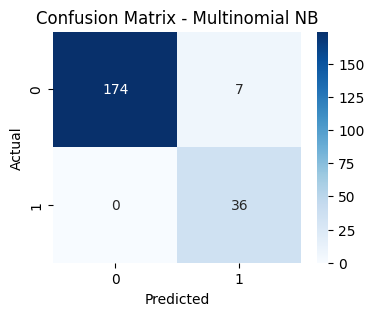


Model: Random Forest
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Mean Cross-Validation Score: 0.9491
Test Accuracy: 0.9631

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       181
           1       1.00      0.78      0.88        36

    accuracy                           0.96       217
   macro avg       0.98      0.89      0.93       217
weighted avg       0.96      0.96      0.96       217



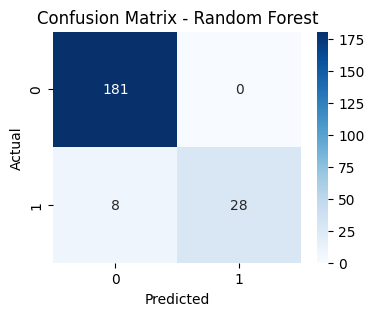


Model: Gradient Boosting
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Mean Cross-Validation Score: 0.9399
Test Accuracy: 0.9539

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.91      0.81      0.85        36

    accuracy                           0.95       217
   macro avg       0.93      0.89      0.91       217
weighted avg       0.95      0.95      0.95       217



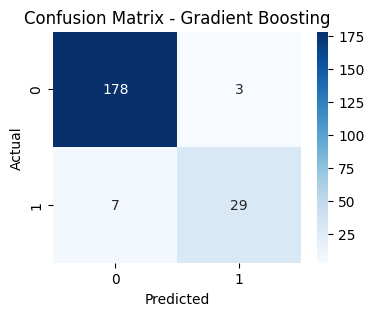


Model: LightGBM
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Mean Cross-Validation Score: 0.9514
Test Accuracy: 0.9724

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       181
           1       0.92      0.92      0.92        36

    accuracy                           0.97       217
   macro avg       0.95      0.95      0.95       217
weighted avg       0.97      0.97      0.97       217



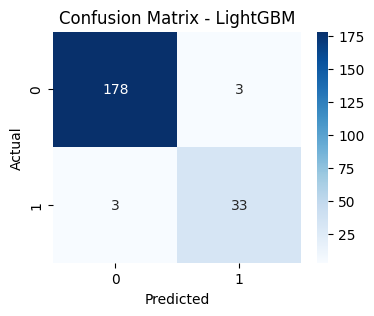


Best Model: SVM with Test Accuracy: 0.9724


In [31]:
best_model_name = None
best_test_accuracy = 0

for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {result['Best Params']}")
    print(f"Mean Cross-Validation Score: {result['Mean CV Score']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("\nClassification Report:")
    print(result['Classification Report'])

    plt.figure(figsize=(4, 3))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    if result['Test Accuracy'] > best_test_accuracy:
        best_test_accuracy = result['Test Accuracy']
        best_model_name = model_name

print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_test_accuracy:.4f}")

In [32]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


In [41]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import joblib
import gradio as gr
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import contractions
import emoji
import warnings
warnings.filterwarnings('ignore')

# Initialize NLTK resources
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Load and preprocess data
train_data = pd.read_csv("SMS_train.csv", encoding='latin1')
test_data = pd.read_csv("SMS_test.csv", encoding='latin1')
merged_data = pd.concat([train_data, test_data], ignore_index=True)
merged_data['Processed_Text'] = merged_data['Message_body'].apply(preprocess_text)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(merged_data['Processed_Text'])
def extract_features(text):
    text_length = len(text)
    avg_word_length = np.mean([len(word) for word in text.split()]) if text.split() else 0
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    return [text_length, avg_word_length, punctuation_count]
custom_features = np.array([extract_features(text) for text in merged_data['Message_body']])
X = np.hstack((X_text.toarray(), custom_features))
y = merged_data['Label'].map({'Spam': 1, 'Non-Spam': 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train SVM model
model = SVC(kernel='linear', C=10, probability=True)
model.fit(X_train, y_train_encoded)
test_accuracy = accuracy_score(y_test_encoded, model.predict(X_test))

# Save model and vectorizer
joblib.dump(model, "best_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

# Gradio GUI setup
last_input_text = ""
last_processed_text = ""

def predict_spam(text):
    global last_input_text, last_processed_text
    if not text.strip():
        return "الرجاء إدخال نص للتصنيف 🚫"
    last_input_text = text
    last_processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([last_processed_text])
    custom_features = np.array([extract_features(text)])
    full_features = np.hstack((vectorized_text.toarray(), custom_features))
    prediction = model.predict(full_features)[0]
    prob = model.predict_proba(full_features)[0]
    return f"{'🚨 Spam' if prediction == 1 else '✅ Not Spam'} (الثقة: {max(prob):.2%})"

def process_text_for_tab(text):
    if not text.strip():
        return "الرجاء إدخال نص للمعالجة 🚫"
    return preprocess_text(text)

# Example messages
spam_examples = [
    "Exclusive offer! Get 50% off your next purchase, click www.dealz.com now!",
    "Congratulations! You’ve won £1000! Call 0800-123-456 NOW to claim your prize!"
]
not_spam_examples = [
    "Hey, can we meet tomorrow at 5 PM?",
    "Mom, I’ll be home for dinner around 8."
]

# Custom CSS for modern styling
css = """
@import url('https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css');
body, .gradio-container {
    background: linear-gradient(to bottom, #e0f2fe, #bfdbfe);
    font-family: 'Tajawal', sans-serif;
    direction: rtl;
    text-align: right;
}
.tab-nav button {
    background: #1e40af;
    color: white;
    border-radius: 10px;
    padding: 10px 20px;
    margin: 5px;
    transition: background 0.3s;
}
.tab-nav button:hover {
    background: #3b82f6;
}
.tab-nav button.selected {
    background: #1e3a8a;
}
.textbox, .output-text {
    border: 2px solid #60a5fa !important;
    border-radius: 10px !important;
    padding: 10px !important;
    background: white;
    box-shadow: 0 2px 6px rgba(0, 0, 0, 0.1);
}
.button {
    background: #16a34a !important;
    color: white !important;
    border-radius: 10px !important;
    padding: 12px 24px !important;
}
.button:hover {
    background: #15803d !important;
}
.example-box {
    background: #f1f5f9;
    border: 1px solid #cbd5e1;
    border-radius: 10px;
    padding: 15px;
    margin-bottom: 10px;
}
h1, h2 {
    color: #1e3a8a;
}
.output-text {
    font-size: 1.1em;
    font-weight: bold;
    color: #1e3a8a;
}
.header-image {
    display: block;
    margin: 0 auto;
    border-radius: 15px;
    box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);
    max-width: 100%;
    height: auto;
}
"""

# Gradio Interface
with gr.Blocks(css=css, theme=gr.themes.Soft()) as demo:
    # Header with Image
    gr.Markdown("""
    # 🛡️ مصنف رسائل SMS الذكي
    اكتشف ما إذا كانت رسائلك Spam أو Not Spam باستخدام تقنيات التعلم الآلي!
    """)
    try:
        gr.Image(
            value="https://microtime.com/wp-content/uploads/2024/09/blogs-spam.jpg",  # Your new image URL
            label="Spam Detection Illustration",
            width=300,
            elem_classes=["header-image"]
        )
    except Exception as e:
        gr.Markdown("⚠️ تعذر تحميل الصورة. تأكد من صحة الرابط أو ارفع صورة محلية.")

    with gr.Tabs():
        # Prediction Tab
        with gr.Tab(label="التصنيف"):
            gr.Markdown("## أدخل رسالة للتصنيف")
            input_text = gr.Textbox(lines=3, placeholder="اكتب رسالة SMS هنا...", label="الرسالة")
            predict_button = gr.Button("صنّف الرسالة")
            output_text = gr.Textbox(label="النتيجة", interactive=False, elem_classes=["output-text"])
            predict_button.click(fn=predict_spam, inputs=input_text, outputs=output_text)

        # Examples Tab
        with gr.Tab(label="أمثلة"):
            gr.Markdown("## أمثلة على الرسائل")
            with gr.Row():
                with gr.Column():
                    gr.Markdown("### رسائل Spam 🚨")
                    for example in spam_examples:
                        with gr.Group(elem_classes=["example-box"]):
                            gr.Markdown(f"**الرسالة**: {example}")
                            gr.Markdown("**التصنيف**: 🚨 Spam")
                with gr.Column():
                    gr.Markdown("### رسائل Not Spam ✅")
                    for example in not_spam_examples:
                        with gr.Group(elem_classes=["example-box"]):
                            gr.Markdown(f"**الرسالة**: {example}")
                            gr.Markdown("**التصنيف**: ✅ Not Spam")

        # Processed Text Tab
        with gr.Tab(label="النص المعالج"):
            gr.Markdown("## النص قبل وبعد المعالجة")
            gr.Markdown("### من آخر تصنيف")
            with gr.Row():
                gr.Textbox(value=lambda: last_input_text, label="النص الأصلي", interactive=False)
                gr.Textbox(value=lambda: last_processed_text if last_input_text else "لم يتم إدخال نص بعد 🚫", label="النص المعالج", interactive=False)
            gr.Markdown("### معالجة نص جديد")
            process_input = gr.Textbox(lines=3, placeholder="أدخل نصًا هنا لمعالجته...", label="النص الأصلي")
            process_button = gr.Button("معالجة النص")
            process_output = gr.Textbox(label="النص المعالج", interactive=False)
            process_button.click(fn=process_text_for_tab, inputs=process_input, outputs=process_output)

        # About Tab
        with gr.Tab(label="حول"):
            gr.Markdown(f"""
            ## حول المشروع
            نظام ذكي لتصنيف رسائل SMS باستخدام تعلم الآلي.
            - **النموذج**: SVM (الدقة: {test_accuracy:.2%})
            - **المميزات**: معالجة النصوص، استخراج الميزات، واجهة تفاعلية
            - **كيفية الاستخدام**: أدخل رسالة في صفحة التصنيف، شاهد الأمثلة، أو راجع النص المعالج
            **تم تطويره بواسطة**: فريق NLP
            """)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f04b4583bdee651170.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
"""
spam example

🎉 Win a £1000 cash prize! Text WIN to 54321 now to claim your reward!

Congratulations! You’re a winner! Click www.freegift.com to claim your £500 voucher!

Free iPhone 14! Reply YES to 67890 to enter our raffle. Limited spots!

"Free entry to win a brand new iPhone! Text WIN to 54321 before midnight!"




not spam exmaple

"Hey, can we meet tomorrow at 5 PM?"

"I forgot my keys at home, can you bring them?"

"Just finished work, heading to the gym now."

"Mom, I’ll be home for dinner around 8."

"Did you watch the game last night? It was awesome!"

"""